In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import roc_curve, auc
import train_evaluate_affine_pnn as te
import json
import csv
import pickle
import os
from scipy.optimize import curve_fit

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device= 'cpu'

# --------------------------------------------------------------------------------
## Step 1: Loading your model 

In [2]:
# update these variables, select a model and number of features
directory = 'models_27_features_[50, 50, 50]_batches_8192_run_3'
num_of_features = 27

In [3]:
'''
SIMPLY RUN THIS CELL, YOU SHOULDN'T NEED TO CHANGE ANYTHING after updating variables above
'''
best_epoch = np.load(f'{directory}/best_epoch.npy', allow_pickle = True)
epoch_loss_train = np.load(f'{directory}/epoch_loss_train.npy', allow_pickle = True)
epoch_loss_test = np.load(f'{directory}/epoch_loss_test.npy', allow_pickle = True)
learning_rate_epochs = np.load(f'{directory}/learning_rate_epochs.npy', allow_pickle = True)

with open(f'{directory}/model_info.json', 'r') as f:
  model_info = json.load(f)

patience = model_info['patience']
model_type = model_info['model_type']
nodes = model_info['Architecture']
scheduler_type = model_info['scheduler_type']
batch_size = model_info['batch_size']
maximum_epoch = model_info['maximum_epoch']
learning_rate = model_info['starting_learning_rate']


model = torch.load(f'{directory}/model_epoch_{best_epoch}.pth')
scaler = joblib.load(f'{directory}/scaler.save') 

feature_list = []
sorted_features = {}

signal_masses = ["260","270","280","290","300","320","350","400","450","500","550","600","650","700","750","800","900"]

for signal_mass in signal_masses:
    signal = "GluGluToRadionToHHTo2G2Tau_M-"+signal_mass
    GluGluToRadionToHHTo2G2Tau_AUC_NN = pd.read_csv(f"Feature_list/{signal}_AUC_NN.csv", index_col = False, on_bad_lines='skip')
    dict_ = {GluGluToRadionToHHTo2G2Tau_AUC_NN.columns[i]:GluGluToRadionToHHTo2G2Tau_AUC_NN[GluGluToRadionToHHTo2G2Tau_AUC_NN.columns[i]][0] for i in range(len(GluGluToRadionToHHTo2G2Tau_AUC_NN.columns))}
    dict_ = {k: v for k, v in sorted(dict_.items(), key=lambda item: item[1], reverse=True)}
    list_ = list(dict_.keys())
    sorted_features[signal_mass] = list_


for sig in sorted_features.keys():
    for i in range(num_of_features):
        if sorted_features[sig][i] not in feature_list:
            feature_list.append(sorted_features[sig][i])

feature_list = feature_list + ['MX']

signal_df, background_df, combine_df, add_to_test_df = te.read_dataframes()

x_train,x_test,x_train_original,x_test_original = te.getTrainTestSplit(combine_df,add_to_test_df)

x_train_unscaled = x_train_original.copy()
x_test_unscaled = x_test_original.copy()

x_test[feature_list] = scaler.transform(x_test[feature_list])
x_train[feature_list] = scaler.transform(x_train[feature_list])

X_test = x_test[feature_list].to_numpy()
X_train = x_train[feature_list].to_numpy()

model.eval()
output_score_train=torch.tensor([]).to(device)
output_score=torch.tensor([]).to(device)
with torch.no_grad():
    for i in range(0, len(X_train), batch_size):
        batch_train = torch.Tensor(X_train[i:i+batch_size]).to(device)
        output_score_train_batched = model(batch_train)
        output_score_train=torch.cat((output_score_train,output_score_train_batched),dim=0)
        # process the output as needed
    for i in range(0, len(X_test), batch_size):
        batch = torch.Tensor(X_test[i:i+batch_size]).to(device)
        output_score_batched = model(batch)
        output_score=torch.cat((output_score,output_score_batched),dim=0)
    #output_score = model(torch.Tensor(X_test).to(device))
    #output_score_train = model(torch.Tensor(X_train).to(device))
print('>> Finshed.')

>> Loading data ...
>> Splitting train/test data ...
torch.Size([8192, 1024]) torch.Size([8192, 1024]) torch.Size([8192, 1024]) torch.Size([8192, 1024])
torch.Size([8192, 1024])
torch.Size([8192, 512]) torch.Size([8192, 512]) torch.Size([8192, 512]) torch.Size([8192, 512])
torch.Size([8192, 512])
torch.Size([8192, 256]) torch.Size([8192, 256]) torch.Size([8192, 256]) torch.Size([8192, 256])
torch.Size([8192, 256])
torch.Size([8192, 128]) torch.Size([8192, 128]) torch.Size([8192, 128]) torch.Size([8192, 128])
torch.Size([8192, 128])
torch.Size([8192, 64]) torch.Size([8192, 64]) torch.Size([8192, 64]) torch.Size([8192, 64])
torch.Size([8192, 64])
torch.Size([8192, 32]) torch.Size([8192, 32]) torch.Size([8192, 32]) torch.Size([8192, 32])
torch.Size([8192, 32])
torch.Size([8192, 1024]) torch.Size([8192, 1024]) torch.Size([8192, 1024]) torch.Size([8192, 1024])
torch.Size([8192, 1024])
torch.Size([8192, 512]) torch.Size([8192, 512]) torch.Size([8192, 512]) torch.Size([8192, 512])
torch.Size(

>> models_27_features_[1024, 512, 256, 128, 64, 32]_batches_8192/graph.pdf saved succesfully...
>> models_27_features_[1024, 512, 256, 128, 64, 32]_batches_8192/graph.png saved succesfully...


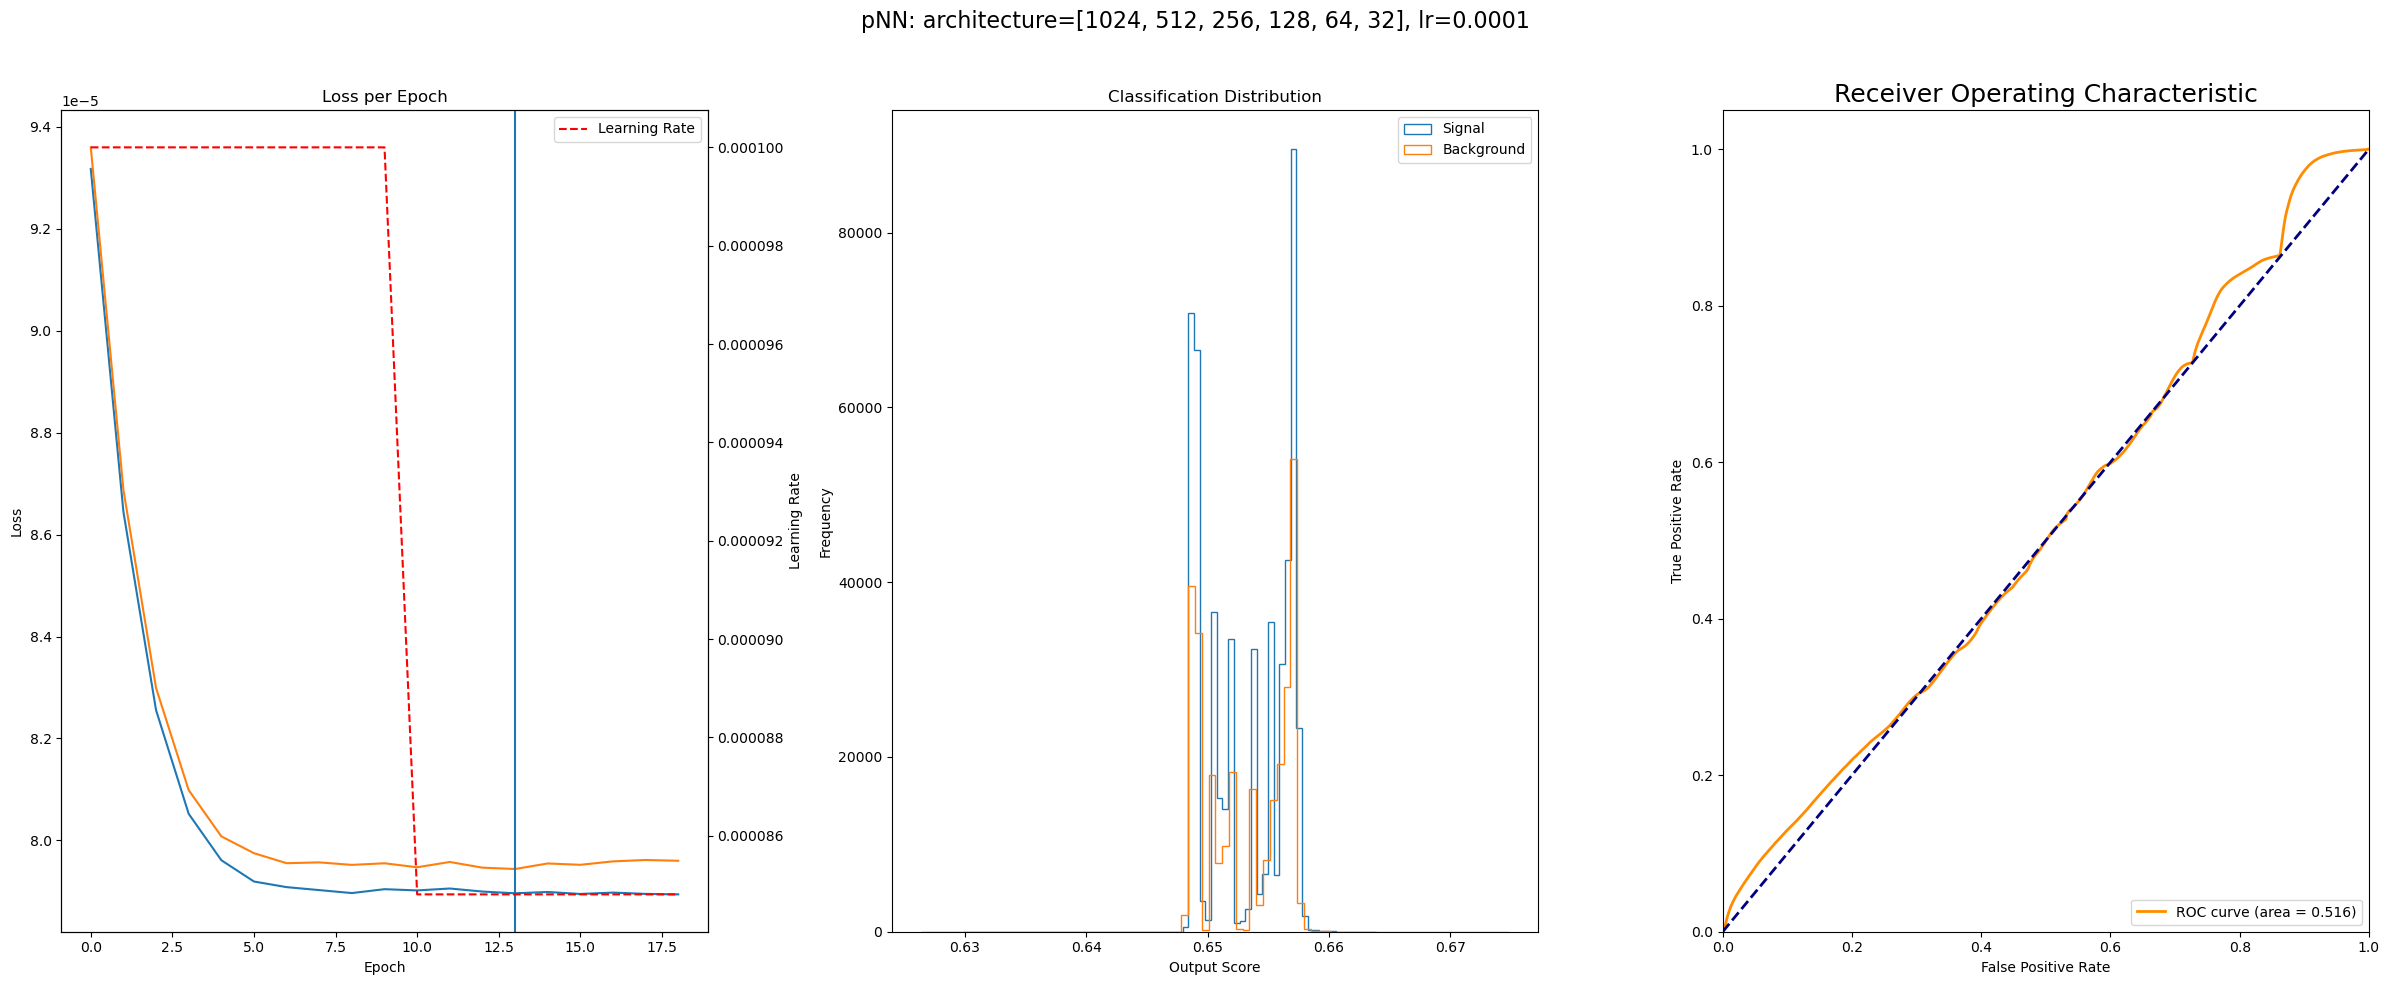

In [4]:
# Update this variable
plot_learning_rate = 'yes'

# You don't have to change anything below.
def separate_output_score(output_score,y):
    dict_ = {'pred':output_score.cpu().detach().numpy().flatten(),'true':y}
    temp_df = pd.DataFrame(dict_)
    signal_output_score = temp_df.loc[temp_df['true'] == 1]['pred']
    background_output_score = temp_df.loc[temp_df['true'] == 0]['pred']
    return signal_output_score,background_output_score

plot_learning_rate = 'yes'

signal_output_score,background_output_score = separate_output_score(output_score,x_test['y'])

    
fpr, tpr, thresholds = roc_curve(x_test['y'], output_score.cpu().detach().numpy())
roc_auc = auc(fpr, tpr)

fig, axs = plt.subplots(1, 3, figsize=(24, 10))
    
line_train,=axs[0].plot(epoch_loss_train, label = 'Train')
line_test,=axs[0].plot(epoch_loss_test, label = 'test')
axs[0].axvline(best_epoch, label = f'Best Performing Epoch - {best_epoch}')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Loss per Epoch')
lines = [line_train,line_test]
if plot_learning_rate == 'yes':
    ax1_twin = axs[0].twinx()
    line_lr,=ax1_twin.plot(learning_rate_epochs, label='Learning Rate', linestyle='--', color='red')
    ax1_twin.set_ylabel('Learning Rate')
    ax1_twin.tick_params(axis='y')
    lines = [line_train,line_test,line_lr]

labels = [line.get_label() for line in lines]
ax1_twin.legend(lines, labels, loc='upper right', fontsize=16)   

axs[1].hist(signal_output_score, label = 'Signal',bins=80,histtype='step')
axs[1].hist(background_output_score, label = 'Background',bins=80,histtype='step')
axs[1].set_xlabel("Output Score")
axs[1].set_title('Classification Distribution')
axs[1].set_ylabel("Frequency")
axs[1].legend()

axs[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
axs[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[2].set_xlim([0.0, 1.0])
axs[2].set_ylim([0.0, 1.05])
axs[2].set_xlabel('False Positive Rate')
axs[2].set_ylabel('True Positive Rate')
axs[2].set_title('Receiver Operating Characteristic',fontsize=18)
axs[2].legend(loc="lower right")
plt.tight_layout()
plt.legend()
#plt.title(f'{signal_names[l]}')
plt.savefig(f'{directory}/graph.pdf',format = 'pdf')
print(f">> {directory}/graph.pdf saved succesfully...")
fig.suptitle(f'pNN: architecture={nodes}, lr={learning_rate}', fontsize=16)
fig.subplots_adjust(top=0.88)
plt.savefig(f'{directory}/graph.png',format = 'png')
print(f">> {directory}/graph.png saved succesfully...")
plt.show()

## Step 2: Testing Individual Signals using the pNN.

In [5]:
'''
SIMPLY RUN THIS CELL, YOU SHOULDN'T NEED TO CHANGE ANYTHING.
'''
def separate_output_score(output_score,y):
    dict_ = {'pred':output_score.cpu().detach().numpy().flatten(),'true':y}
    temp_df = pd.DataFrame(dict_)
    signal_output_score = temp_df.loc[temp_df['true'] == 1]['pred']
    background_output_score = temp_df.loc[temp_df['true'] == 0]['pred']
    return signal_output_score,background_output_score

print(f'>> All graphs and output score data will be saved in: {directory} ...')
allmasses=['260','270','280','290','300','320','350','400','450','500','550','600','650','700','750','800','900','1000']

model_auc = {}

for mass_eval in allmasses:

    signal_mass = int(mass_eval)
    
    x_test_global_signal = x_test_unscaled[x_test_unscaled['y'] == 1]
    x_test_global_background = x_test_unscaled[x_test_unscaled['y'] == 0]
    
    filtered_df_signal = x_test_global_signal[x_test_global_signal['MX'] == signal_mass]
    x_test_global_background.loc[:, 'MX'] = signal_mass
    combine_test_data = pd.concat([filtered_df_signal,x_test_global_background])
    test_df = combine_test_data.sample(frac=1,random_state = 42).reset_index(drop=True)
    
    test_df[feature_list] = scaler.transform(test_df[feature_list])
    
    X_test = test_df[feature_list].to_numpy()

    
    model.eval()
    with torch.no_grad():
        output_score_testing_individual = model(torch.Tensor(X_test).to(device))

    signal_testing_info = {
        'output_score':output_score_testing_individual,
        'y': test_df['y'],
        'weight_central': test_df['weight_central']
    }

    with open(f'{directory}/output_score_signal_{signal_mass}.pkl', 'wb') as f:
            pickle.dump(signal_testing_info, f)
    print(f'>> Saved output score in: output_score_signal_{signal_mass}.pkl ...')
    
    signal_output_score_test,background_output_score_test = separate_output_score(output_score_testing_individual,test_df['y'])
    
    fpr, tpr, thresholds = roc_curve(test_df['y'], output_score_testing_individual.cpu().detach().numpy())
    roc_auc = auc(fpr, tpr)
    
    fig, axs = plt.subplots(1, 2, figsize=(24, 10))
            
        
    # ax1_twin.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))
    
    axs[0].hist(signal_output_score_test, label = 'Signal',bins=80,histtype='step')
    axs[0].hist(background_output_score_test, label = 'Background',bins=80,histtype='step')
    axs[0].set_xlabel("Output Score")
    axs[0].set_title('Classification Distribution')
    axs[0].set_ylabel("Frequency")
    axs[0].legend()
    
    axs[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title('Receiver Operating Characteristic',fontsize=18)
    axs[1].legend(loc="lower right")
    plt.tight_layout()
    plt.legend()
    plt.savefig(f'{directory}/test_{str(signal_mass)}_graph.pdf',format = 'pdf')
    fig.suptitle(f'Signal Mass {str(signal_mass)} GeV')
    fig.subplots_adjust(top=0.88)
    plt.savefig(f'{directory}/test_{str(signal_mass)}_graph.png',format = 'png')
    plt.show()

    model_auc[signal_mass] = roc_auc


with open(f'{directory}/Single_mass_feature_{num_of_features}_auc.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, model_auc.keys())
    w.writeheader()
    w.writerow(model_auc)

>> All graphs and output score data will be saved in: models_27_features_[1024, 512, 256, 128, 64, 32]_batches_16384 ...


KeyboardInterrupt: 

# --------------------------------------------------------------------------------
# Plot each signal mass vs AUC score 

In [ ]:
# Add the path of the auc file
feature_27_base = pd.read_csv(f'models_27_features_[50, 50, 50]/Single_mass_feature_27_auc.csv')
feature_27_high_batch = pd.read_csv(f'models_27_features_[50, 50, 50]_batch_size_131072/Single_mass_feature_27_auc.csv')
feature_27_dynamic_batch = pd.read_csv(f'models_27_features_[50, 50, 50]_dynamic_batch_size/Single_mass_feature_27_auc.csv')
feature_27_dynamic_batch_scheduler = pd.read_csv(f'models_27_features_[50, 50, 50]_dynamic_batch_size+scheduler/Single_mass_feature_27_auc.csv')
feature_27_scheduler_50_100_100_50 = pd.read_csv(f'models_27_features_[50, 100, 100, 50]/Single_mass_feature_27_auc.csv')
feature_27_batch_4096_1024_512_256_128_64_32 = pd.read_csv(f'models_27_features_[1024, 512, 256, 128, 64, 32]_batches_4096/Single_mass_feature_27_auc.csv')

# add the file into the dictionary, the key will be the label for the graph
plotting = {
    'Scheduler only pNN, node: [50, 50, 50] (Union of 27 Features)': feature_27_base,
    'High Batch pNN, node: [50, 50, 50] (Union of 27 Features)': feature_27_high_batch,
    'Dynamic Batch pNN, node: [50, 50, 50] (Union of 27 Features)': feature_27_dynamic_batch,
    'Dynamic Batch pNN + Scheduler, node: [50, 50, 50] (Union of 27 Features)': feature_27_dynamic_batch_scheduler,
    'Scheduler only pNN, node: [50, 100, 100, 50] (Union of 27 Features)': feature_27_scheduler_50_100_100_50,
    '4096 Batch Size pNN, node: [1024, 512, 256, 128, 64, 32] (Union of 27 Features)': feature_27_batch_4096_1024_512_256_128_64_32
}

>> Directory exists ...
>> pNN_Graphs/pNN_Comparison.png saved...
>> pNN_Graphs/pNN_Comparison.pdf saved...


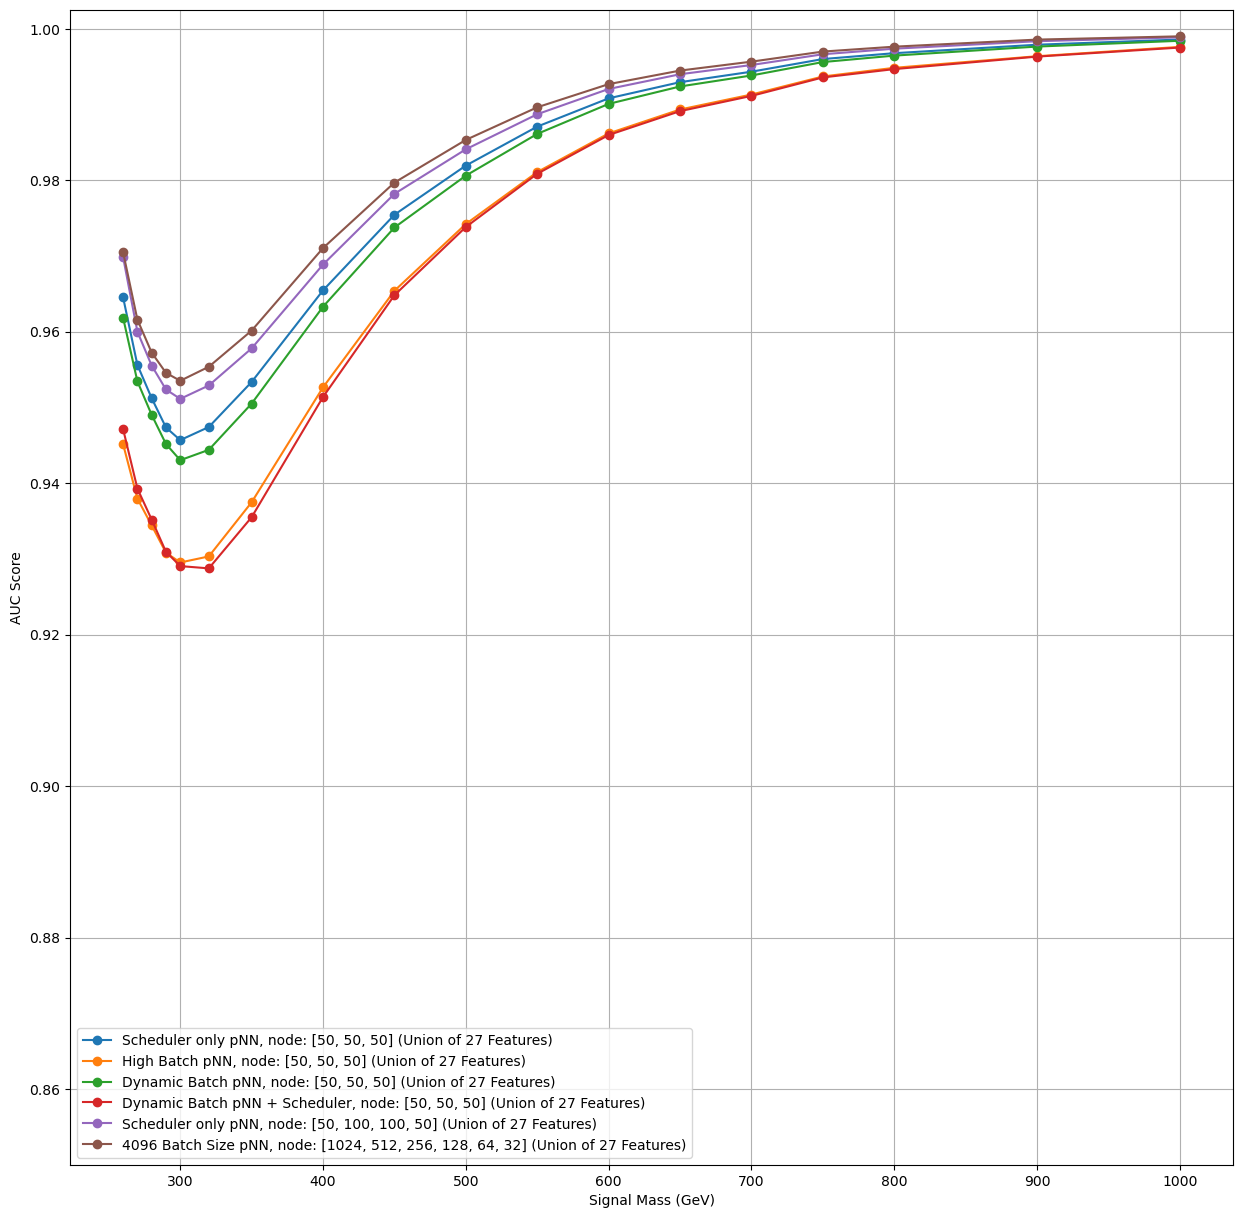

In [ ]:
# Update these variables below
file_name_of_graph = 'pNN_Comparison'
directory_for_graph = 'pNN_Graphs'


#Nothing below needs to be changed, please only update cell above.
if not os.path.exists(directory_for_graph):
    # Create the directory
    os.makedirs(directory_for_graph)
    print(">> Directory created successfully ...")
else:
    print(">> Directory exists ...")

allmasses=['260','270','280','290','300','320','350','400','450','500','550','600','650','700','750','800','900','1000']
int_masses = [int(i) for i in allmasses]
plt.figure(figsize=(15,15))
for key, value in plotting.items():
    roc_auc = []
    for key_plot in value.keys():
        roc_auc.append(value[key_plot].item())
    plt.plot(int_masses,roc_auc, marker = 'o',label = key)
plt.xlabel('Signal Mass (GeV)')
plt.ylabel('AUC Score')
plt.ylim(bottom = 0.85)
plt.legend()
plt.grid()
plt.savefig(f'{directory_for_graph}/{file_name_of_graph}.png',format = 'png')
plt.savefig(f'{directory_for_graph}/{file_name_of_graph}.pdf',format = 'pdf')
print(f">> {directory_for_graph}/{file_name_of_graph}.png saved...")
print(f">> {directory_for_graph}/{file_name_of_graph}.pdf saved...")
plt.show()
    

# --------------------------------------------------------------------------------
# Expected Upper Limit

In [21]:
"""
Set up the range you wish to scan the thresholds with classification range 
"""
classification_range = [0.9,1]
increments=0.001
Diphoton_mass_range=[123.73,125.82]
Diphoton_ranges=[[123.73,125.82],[123.21,126.34],[122.69,126.86],[122.17,127.39],[121.64,127.91]]
Diphoton_ranges=[[122.69,126.86],[122.17,127.39],[121.64,127.91]]
Diphoton_ranges=[[124.25, 125.30]]



In [20]:
factor=1/2
lower_std = mean_fit - standard_deviation_fit*factor
higher_std = mean_fit +  standard_deviation_fit*factor
print(lower_std, higher_std)

124.25356937770783 125.29773438013908


260 123.50935903093102 125.98459453036838
270 123.48309776887493 125.9716293989263
280 123.49309734451715 125.96343336848814
290 123.50326181750903 125.9514382345716
300 123.48926760660268 126.00520707171552
320 123.59995956744714 125.90098694456651
350 123.60351167440015 125.90507981331032
400 123.63318630198674 125.89246094971952
450 123.69842440033769 125.84676807382412
500 123.7437254972811 125.81741411709015
550 123.75449773161468 125.81783355484642
600 123.78643176910506 125.78687493269828
650 123.80523128963597 125.79564957097227
700 123.81220518313725 125.7568344534755
750 123.84716689463232 125.75448592859178
800 123.85811310118518 125.74106769172252
900 123.87399409868523 125.71070852612918
1000 123.86281211019147 125.70072724340878
total signal set: 123.73148687649221 125.8198168813547


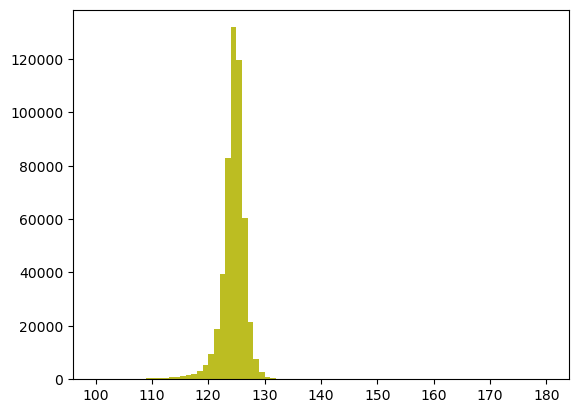

In [14]:

def gaussian(x, amplitude, mean, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2 * standard_deviation*2))
allmasses=['260','270','280','290','300','320','350','400','450','500','550','600','650','700','750','800','900','1000']

#mass_hypothesis = 1000
for mass_hypothesis in allmasses:
    mass_hypothesis=int(mass_hypothesis)
    data = x_test_global_signal[x_test_global_signal['MX']==mass_hypothesis]['Diphoton_mass']#put diphoton_mass data here, eg output_score_signal_1000['Diphoton_mass']

    count, bins, _ = plt.hist(data, range=(100, 180), bins=80)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    initial_guess = [max(count), 125, 1]
    params, covariance = curve_fit(gaussian, bin_centers, count, p0=initial_guess)

    amplitude_fit, mean_fit, standard_deviation_fit = params

    lower = mean_fit - standard_deviation_fit
    higher = mean_fit +  standard_deviation_fit
    print(mass_hypothesis,lower, higher)

data = x_test_global_signal['Diphoton_mass']#put diphoton_mass data here, eg output_score_signal_1000['Diphoton_mass']

count, bins, _ = plt.hist(data, range=(100, 180), bins=80)
bin_centers = (bins[:-1] + bins[1:]) / 2

initial_guess = [max(count), 125, 1]
params, covariance = curve_fit(gaussian, bin_centers, count, p0=initial_guess)

amplitude_fit, mean_fit, standard_deviation_fit = params

lower = mean_fit - standard_deviation_fit
higher = mean_fit +  standard_deviation_fit
print('total signal set:', lower, higher)
#filtered_df should contain all the data in that region
#filtered_df = output_score_signal_1000[(output_score_signal_1000['Diphoton_mass'] > lower) & (output_score_signal_1000['Diphoton_mass'] < higher)]

260 3.1890869140625 [124.25, 125.3]


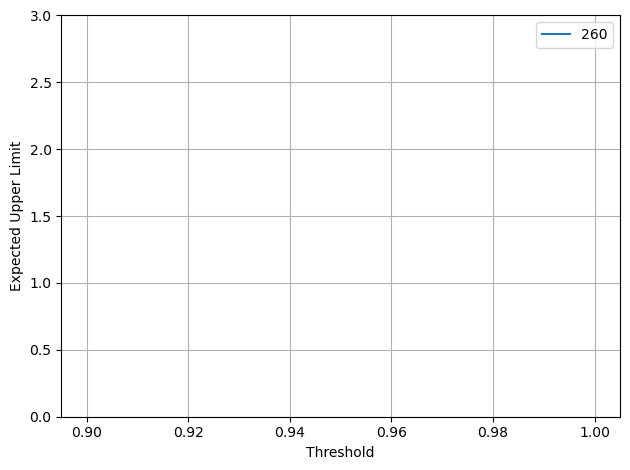

270 3.2501220703125 [124.25, 125.3]


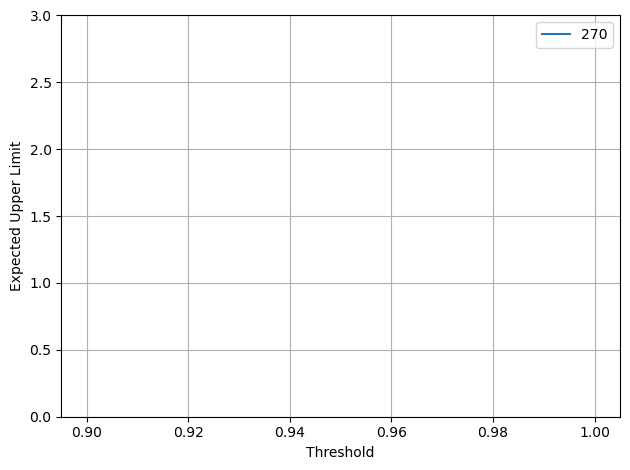

280 3.2928466796875 [124.25, 125.3]


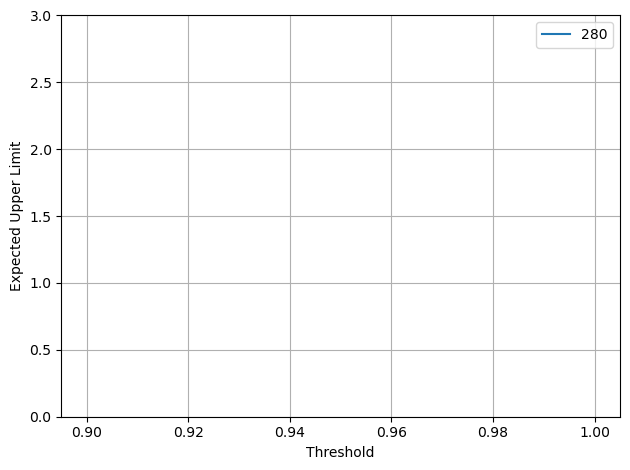

290 3.1646728515625 [124.25, 125.3]


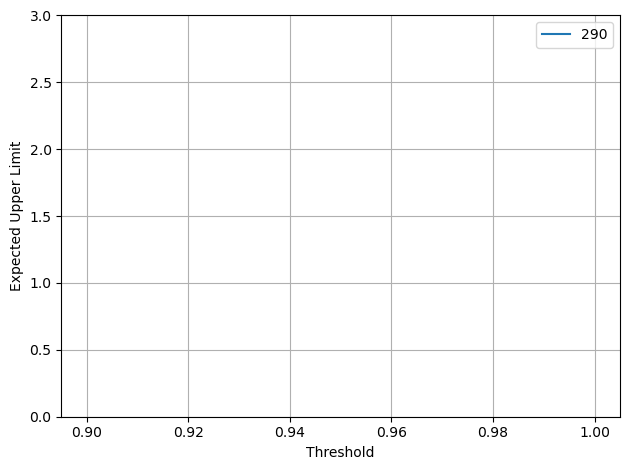

300 2.72064208984375 [124.25, 125.3]


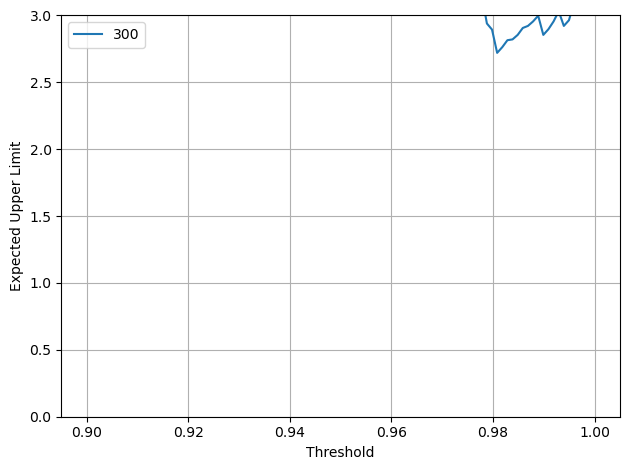

320 2.43377685546875 [124.25, 125.3]


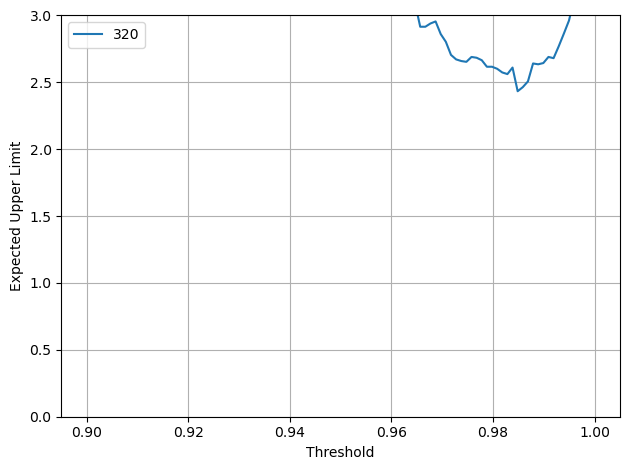

350 2.18353271484375 [124.25, 125.3]


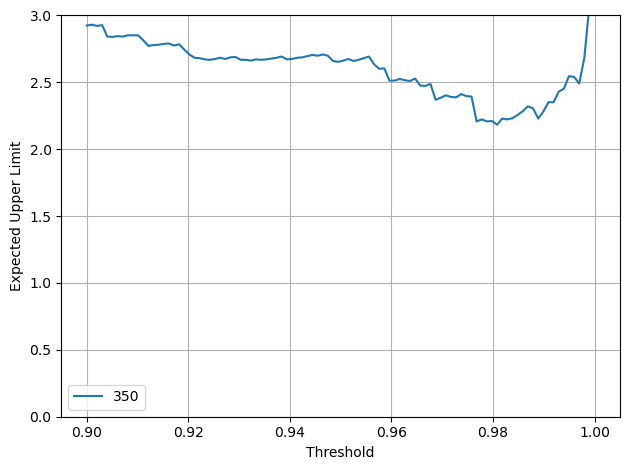

c:\Users\drpla\Desktop\ICL-PHYSICS-YEAR-4\Masters Project\GIT\CMS_Physics_PNN\Neural Networks\pNN_Final\train_evaluate_pnn.py:532: RuntimeWarning: invalid value encountered in log
  qmu = -2 * np.sum( b*(np.log(mu*s+b) - np.log(b)) - mu*s )
c:\Users\drpla\Desktop\ICL-PHYSICS-YEAR-4\Masters Project\GIT\CMS_Physics_PNN\Neural Networks\pNN_Final\train_evaluate_pnn.py:541: UserWarning: Limit above rhigh = 100.000000
  warnings.warn("Limit above rhigh = %f"%rhigh)


400 1.396942138671875 [124.25, 125.3]


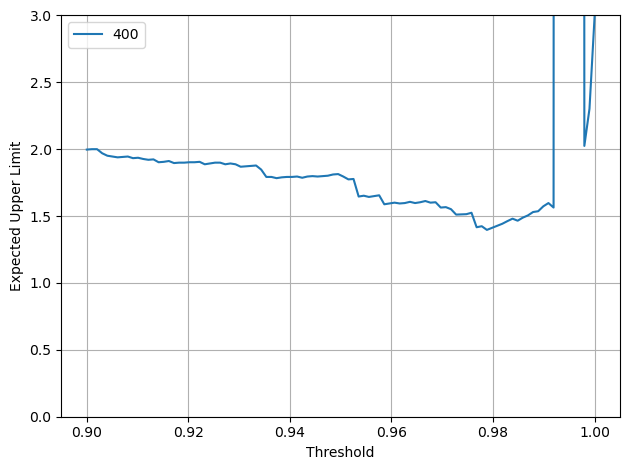

450 1.221466064453125 [124.25, 125.3]


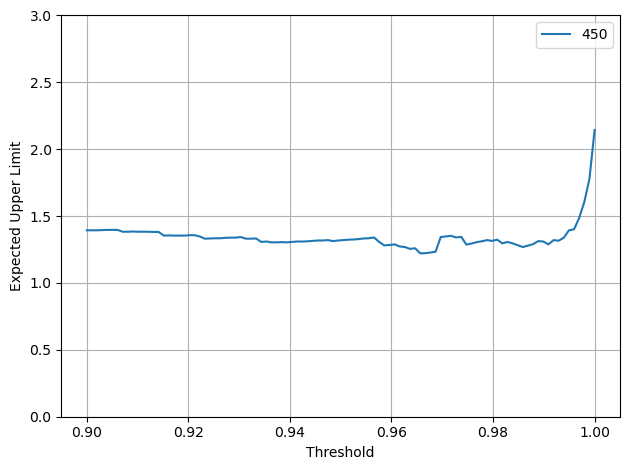

500 0.981903076171875 [124.25, 125.3]


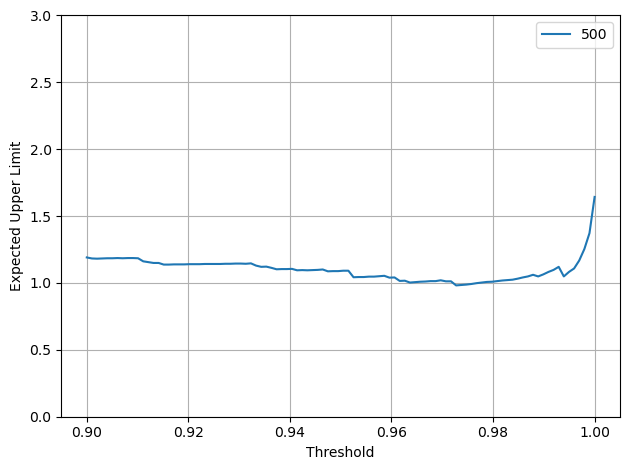

550 0.890350341796875 [124.25, 125.3]


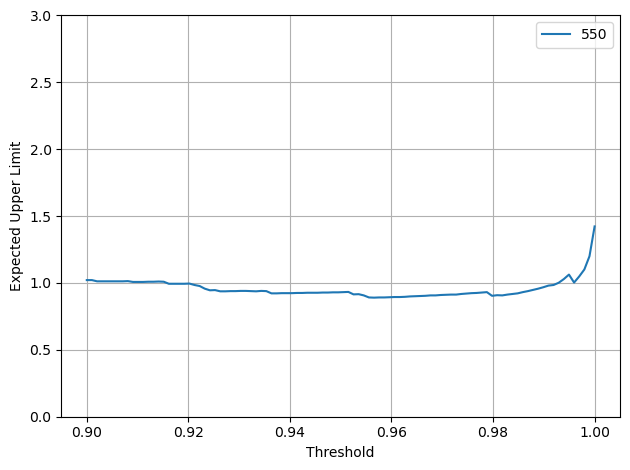

600 0.783538818359375 [124.25, 125.3]


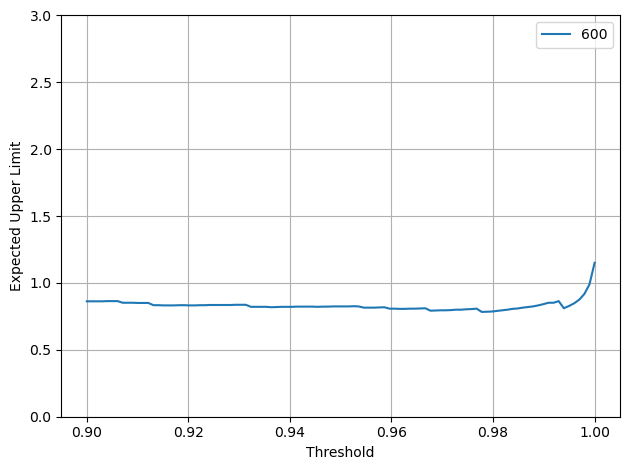

650 0.6855010986328125 [124.25, 125.3]


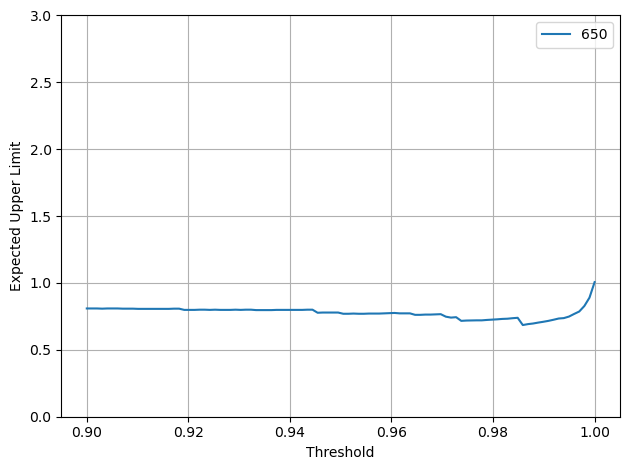

700 0.6343841552734375 [124.25, 125.3]


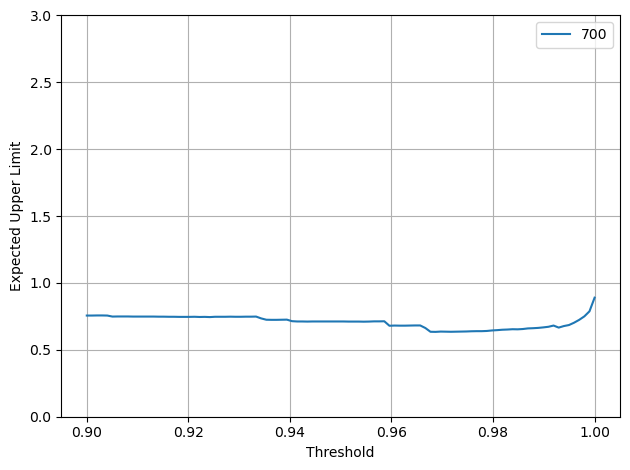

750 0.5847930908203125 [124.25, 125.3]


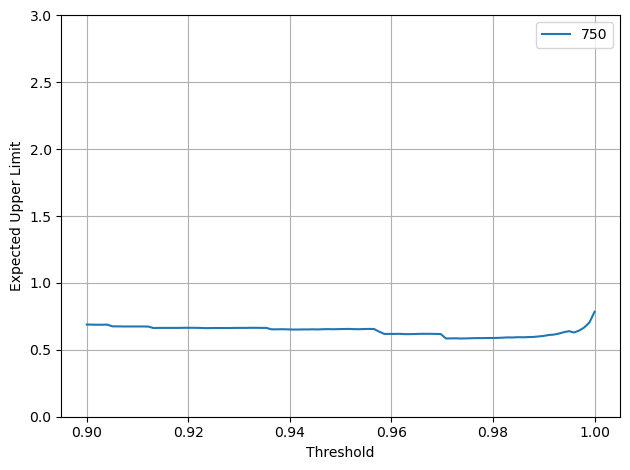

800 0.5847930908203125 [124.25, 125.3]


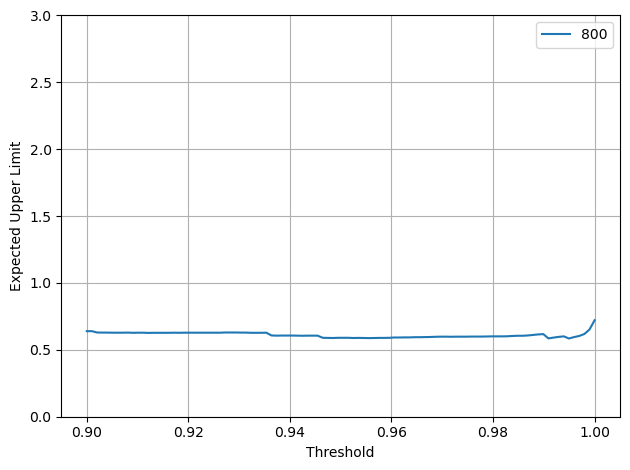

900 0.5268096923828125 [124.25, 125.3]


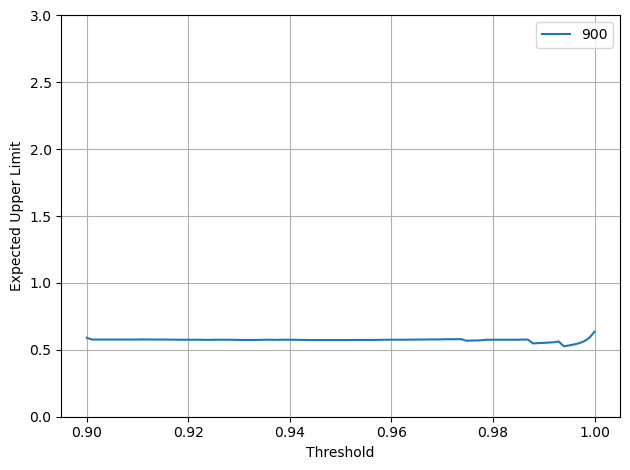

1000 0.5077362060546875 [124.25, 125.3]


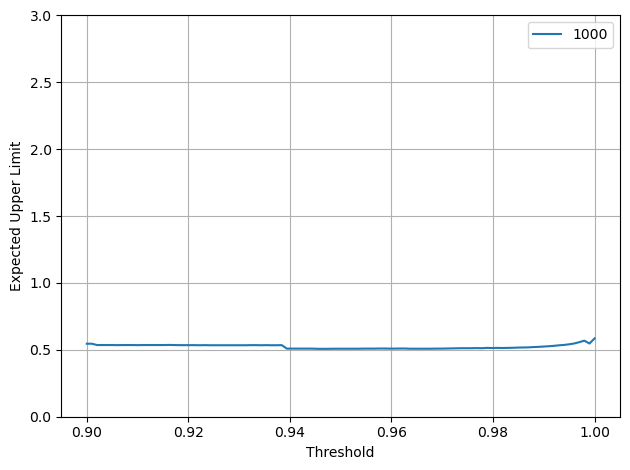

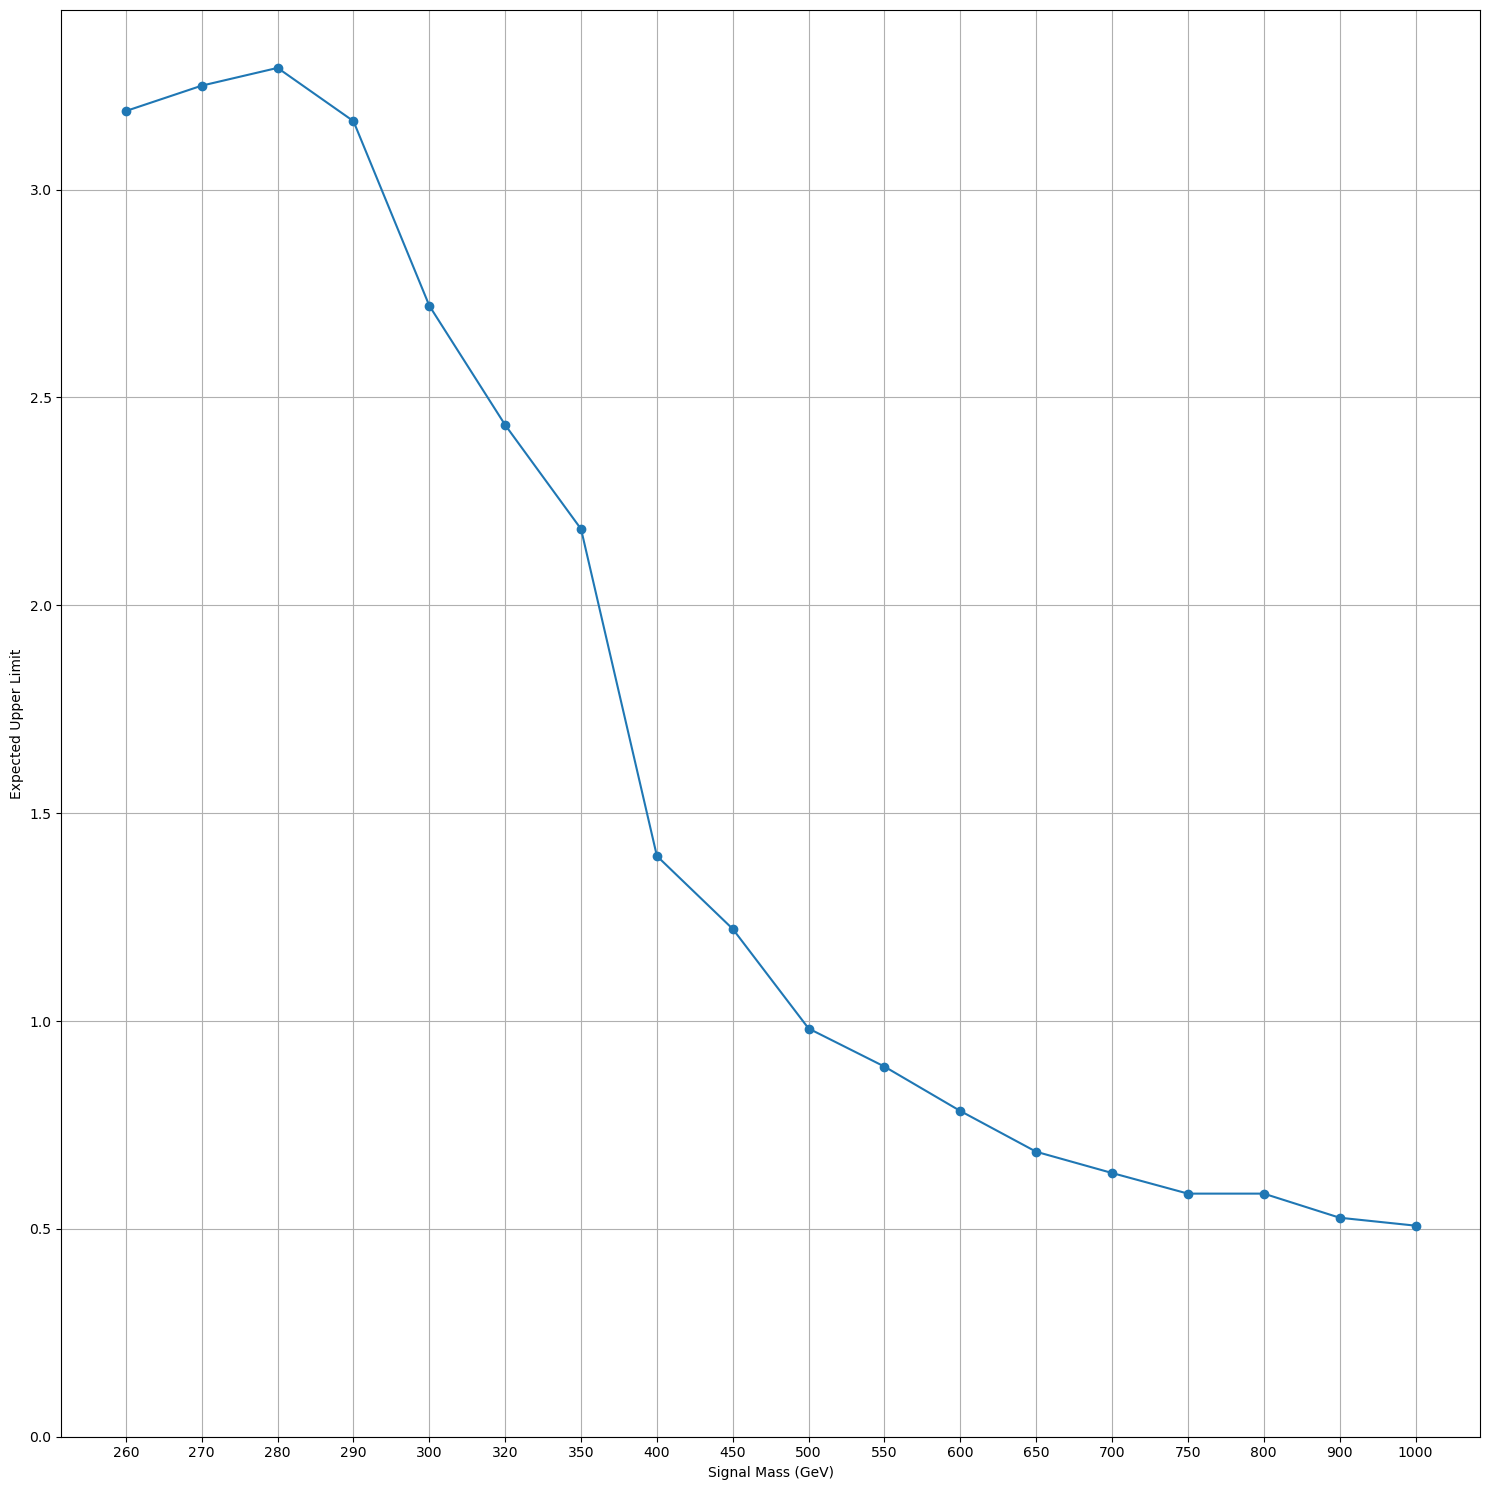

In [22]:

allmasses=['260','270','280','290','300','320','350','400','450','500','550','600','650','700','750','800','900','1000']

model_auc = {}

model = torch.load(f'{directory}/model_epoch_{best_epoch}.pth')
for Diphoton_mass_range in Diphoton_ranges:   
    listofminimumvalues=[]
    for mass_eval in allmasses:
        signal_mass = int(mass_eval)
        x_test_global_signal = x_test_unscaled[x_test_unscaled['y'] == 1]
        allmasses=['260','270','280','290','300','320','350','400','450','500','550','600','650','700','750','800','900','1000']
        x_test_global_background = x_test_unscaled[x_test_unscaled['y'] == 0]
        filtered_df_signal = x_test_global_signal[x_test_global_signal['MX'] == signal_mass]
        x_test_global_background.loc[:, 'MX'] = signal_mass
        combine_test_data = pd.concat([filtered_df_signal,x_test_global_background])
        test_df = combine_test_data.sample(frac=1).reset_index(drop=True)
        test_df_unscaled=test_df.copy()
        test_df[feature_list] = scaler.transform(test_df[feature_list])
        X_test = test_df[feature_list].to_numpy()
        model.eval()
        with torch.no_grad():
            output_score_testing_individual = model(torch.Tensor(X_test).to(device))
        
        

        signal_output_score_test,background_output_score_test = te.Diphoton_mass_output_score_v2(test_df_unscaled,output_score_testing_individual,test_df['y'],Diphoton_mass_range)
        expected_limits=[]    
        threshold_classification=[]
        for threshold in np.arange(classification_range[0], classification_range[1], increments):
            s=sum(signal_output_score_test[signal_output_score_test['pred']>=threshold].weight_central)
            b=sum(background_output_score_test[background_output_score_test['pred']>threshold].weight_central)
            if threshold < 1:
                expectedL=te.calculateExpectedLimit(s,b,rhigh=100.0)
                expected_limits.append(expectedL)
                threshold_classification.append(threshold)

        plt.plot(np.linspace(classification_range[0],classification_range[1],len(expected_limits)),expected_limits,label=f'{mass_eval}')
        plt.legend()
        plt.ylim(0,3)
        plt.xlabel('Threshold')
        plt.ylabel('Expected Upper Limit')
        minimumvalue=min(expected_limits)
        print(mass_eval,minimumvalue, Diphoton_mass_range)
        listofminimumvalues.append(minimumvalue)
        plt.grid()
        plt.tight_layout()
        plt.savefig(f'{directory}/ExpectedUpperLimit/thresholdupperlimitplots_{mass_eval}_{Diphoton_mass_range}.png')
        plt.show()
        data = list(zip(threshold_classification, expected_limits))
        featurescore_df = pd.DataFrame(data, columns=['threshold','expected_limits'])
        
        output_file_path = f'{directory}/ExpectedUpperLimit/thresholdupperlimitplots_{mass_eval}_{Diphoton_mass_range}.csv'
        featurescore_df.to_csv(output_file_path, index=False)


    plt.figure(figsize=(15,15))

    plt.plot(allmasses,listofminimumvalues,marker='o')
    plt.savefig(f'{directory}/ExpectedUpperLimit/EUL_MX_MassRange_{Diphoton_mass_range}.png')
    plt.xlabel('Signal Mass (GeV)')
    plt.ylabel('Expected Upper Limit')
    plt.ylim(0,)
    plt.grid()
    plt.tight_layout()
    plt.show()

    featurescore_df = pd.DataFrame(listofminimumvalues, columns=[str(Diphoton_mass_range)])
        
    output_file_path = f'{directory}/ExpectedUpperLimit/EUL_MX_MassRange_{Diphoton_mass_range}.csv'
    featurescore_df.to_csv(output_file_path, index=False)




#test_df_unscaled[(test_df_unscaled['Diphoton_mass'] >400) & (test_df_unscaled['Diphoton_mass'] < 501)]

0.995
1.93634033203125
0.988
1.274871826171875
0.993
0.2935409545898437


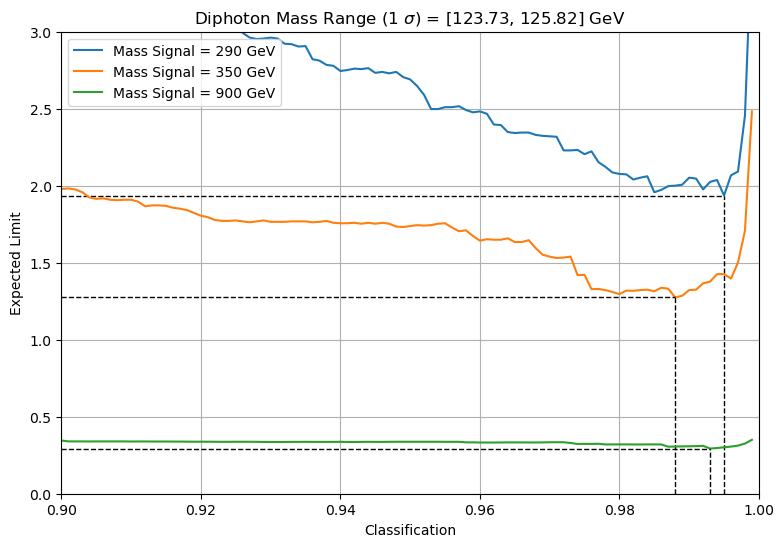

In [3]:
EL_plots = ['thresholdupperlimmitplots_290_[123.73, 125.82].csv',
            'thresholdupperlimmitplots_350_[123.73, 125.82].csv',
            'thresholdupperlimmitplots_900_[123.73, 125.82].csv']
lines_name = ['290', '350', '900']
fig = plt.figure(figsize=(9,6))
lines = []  # Initialize an empty list to store plot lines
j = 0
for i in EL_plots:
    df = pd.read_csv(f'{directory}/ExpectedUpperLimit/{i}')
    thresh = df['threshold']
    expectedlim = df['expected_limits']
    plotline, = plt.plot(thresh, expectedlim, label=f'Mass Signal = {lines_name[j]} GeV')
    minima=df[df['expected_limits']==min(expectedlim)].values
    min_thresh=minima[0][0]
    print(min_thresh)
    min_expectedlim=minima[0][1]
    plt.axvline(min_thresh, color='black', linestyle='--', ymin=0, ymax=min_expectedlim/3,linewidth=1)
    plt.axhline(min_expectedlim, color='black', linestyle='--', xmin=0, xmax=(min_thresh*10-9),linewidth=1)


    print(min(expectedlim))
    lines.append(plotline)
    j += 1

labels = [line.get_label() for line in lines]
plt.legend(lines, labels,loc='upper left')
plt.grid()
plt.ylim(0, 3)
plt.xlim(0.9,1)
plt.ylabel('Expected Limit')
plt.xlabel('Classification')
plt.title(r'Diphoton Mass Range (1 $\sigma$) = [123.73, 125.82] GeV')
plt.show()

0.995
3.1890869140625
0.977
2.26593017578125
0.996
1.74407958984375
0.995
1.60064697265625
0.995
1.511383056640625
0.996
1.506805419921875


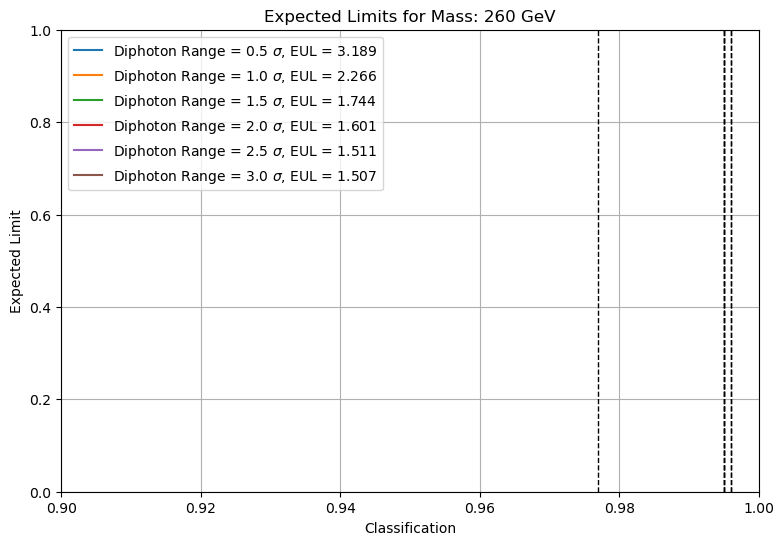

0.986
3.2501220703125
0.987
2.12860107421875
0.986
1.69219970703125
0.993
1.57012939453125
0.993
1.490020751953125
0.993
1.496124267578125


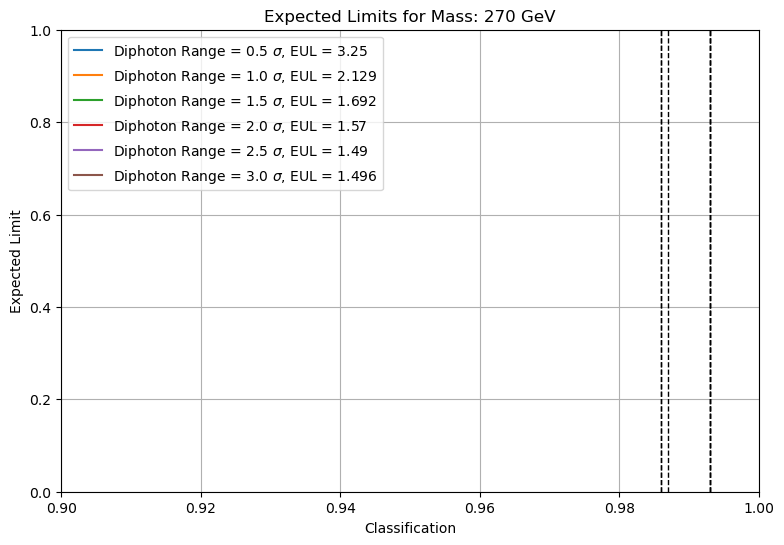

0.986
3.2928466796875
0.992
1.96075439453125
0.992
1.55792236328125
0.992
1.490020751953125
0.994
1.473236083984375
0.994
1.464080810546875


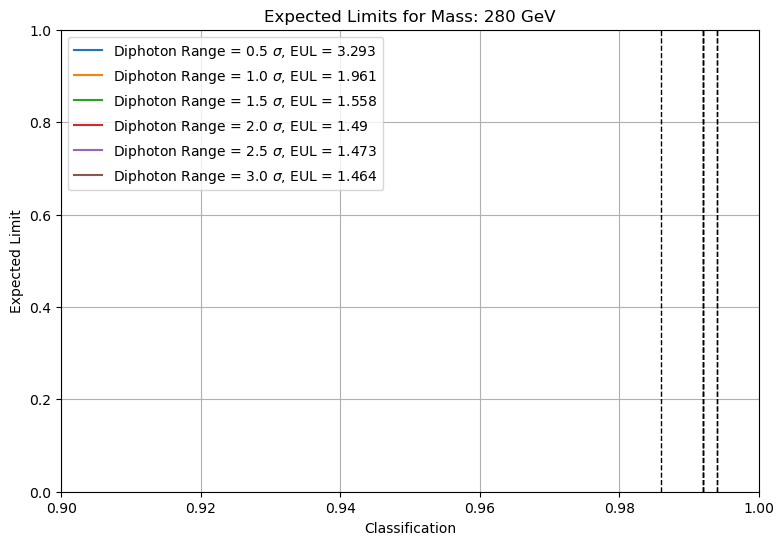

0.995
3.1646728515625
0.995
1.93634033203125
0.995
1.491546630859375
0.995
1.393890380859375
0.995
1.412200927734375
0.988
1.427459716796875


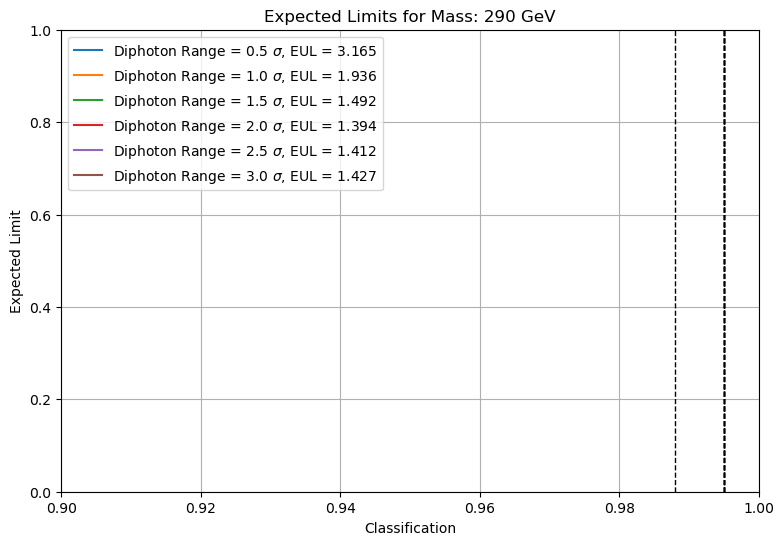

0.98
2.72064208984375
0.994
1.84173583984375
0.996
1.505279541015625
0.996
1.371002197265625
0.995
1.392364501953125
0.989
1.409149169921875


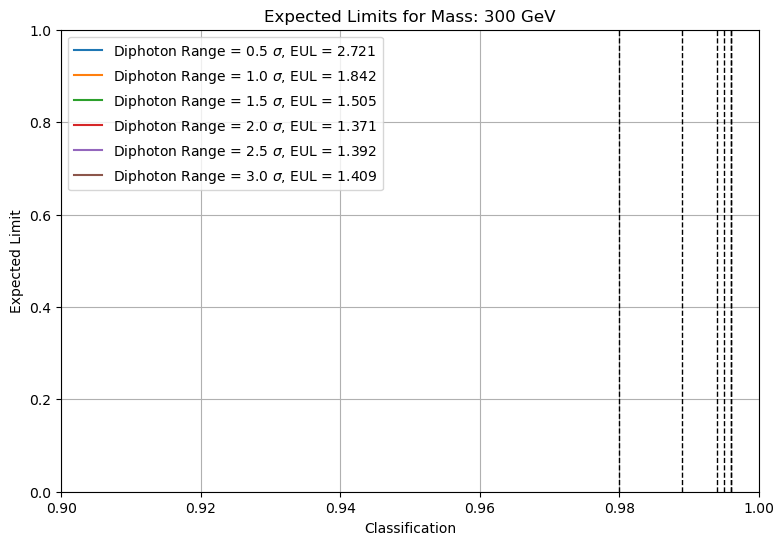

0.984
2.43377685546875
0.984
1.69830322265625
0.989
1.483917236328125
0.992
1.383209228515625
0.992
1.322174072265625
0.992
1.338958740234375


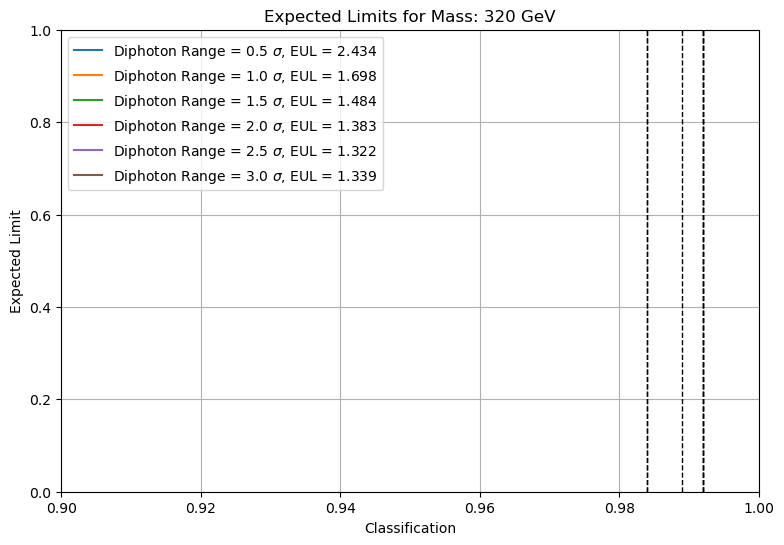

0.98
2.18353271484375
0.988
1.274871826171875
0.992
1.068878173828125
0.995
1.039886474609375
0.995
0.968170166015625
0.994
1.065826416015625


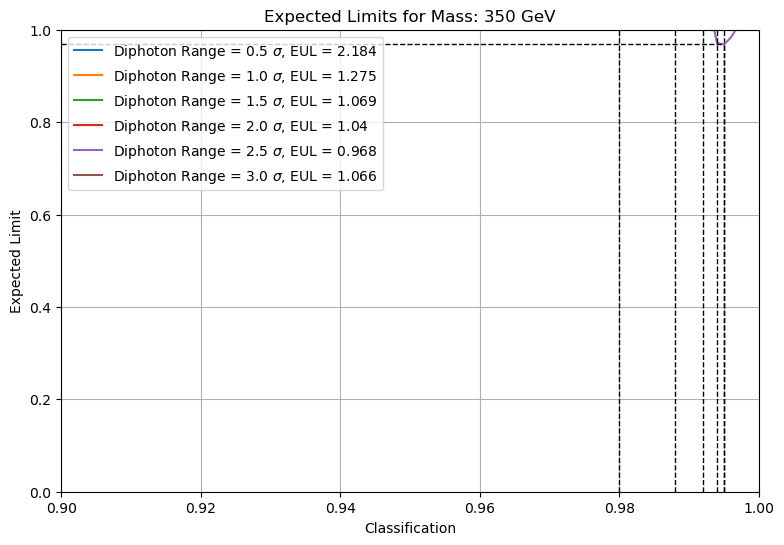

0.978
1.396942138671875
0.977
0.856781005859375
0.977
0.821685791015625
0.982
0.774383544921875
0.983
0.7419586181640625
0.994
0.7396697998046875


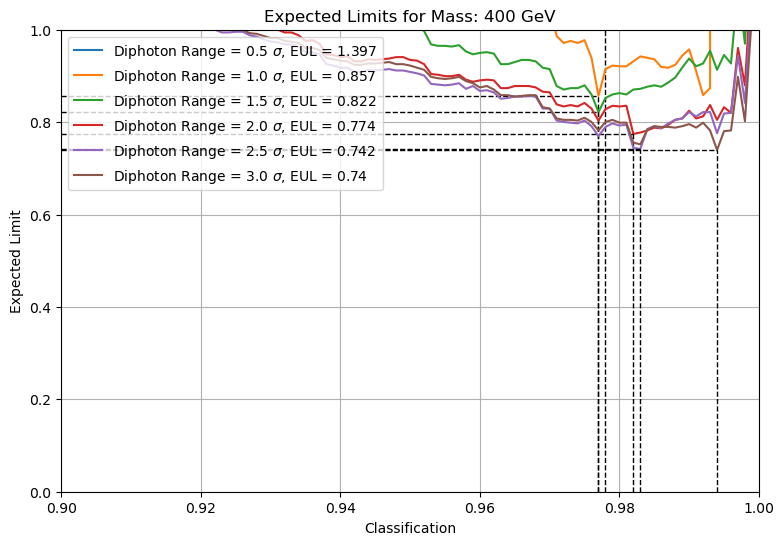

0.965
1.221466064453125
0.992
0.814056396484375
0.992
0.6923675537109375
0.996
0.6397247314453125
0.992
0.6191253662109375
0.992
0.6053924560546875


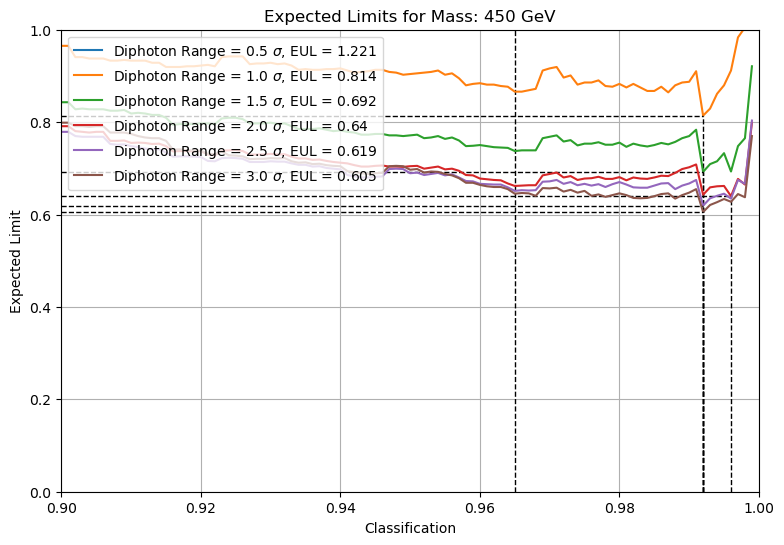

0.972
0.981903076171875
0.993
0.6290435791015625
0.993
0.4909515380859375
0.993
0.4482269287109375
0.993
0.4688262939453125
0.993
0.4459381103515625


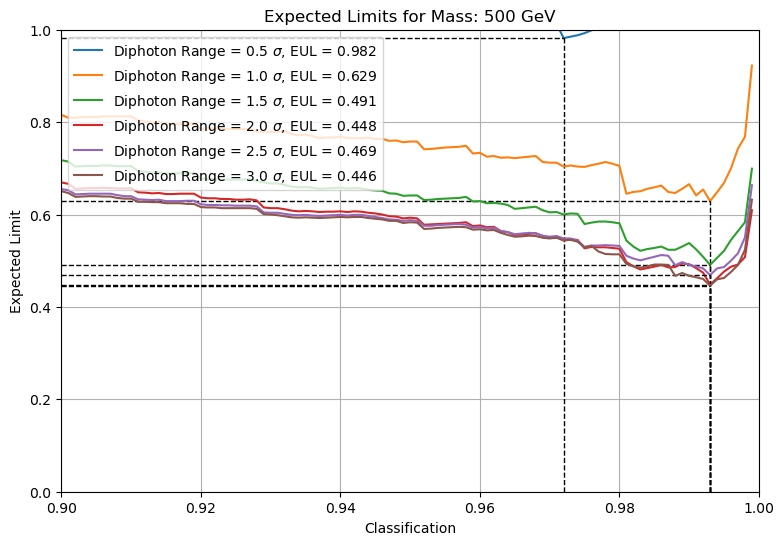

0.956
0.890350341796875
0.979
0.5382537841796875
0.979
0.4375457763671875
0.985
0.4062652587890625
0.991
0.4093170166015625
0.979
0.3963470458984375


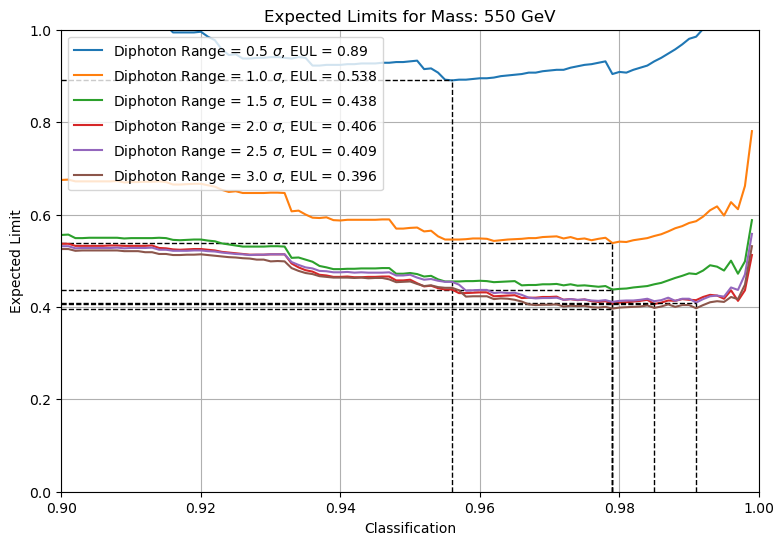

0.977
0.783538818359375
0.977
0.4695892333984375
0.977
0.3808975219726562
0.977
0.3492355346679687
0.996
0.3358840942382812
0.996
0.3217697143554687


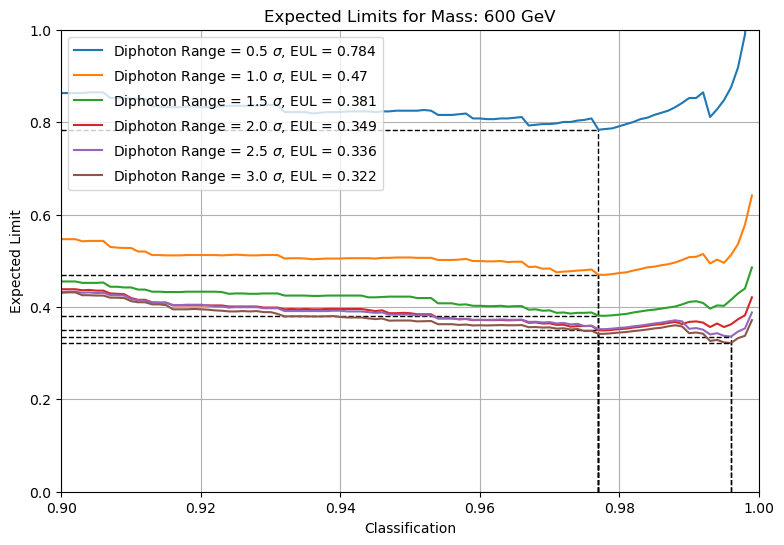

0.985
0.6855010986328125
0.985
0.4230499267578125
0.994
0.3374099731445312
0.994
0.2927780151367187
0.994
0.2752304077148437
0.994
0.2653121948242187


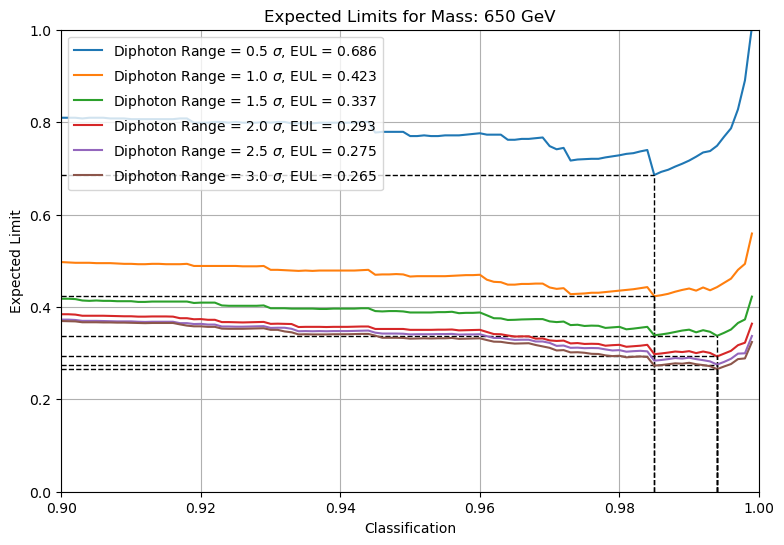

0.968
0.6343841552734375
0.977
0.3894805908203125
0.992
0.3049850463867187
0.992
0.2653121948242187
0.992
0.2519607543945312
0.992
0.2111434936523437


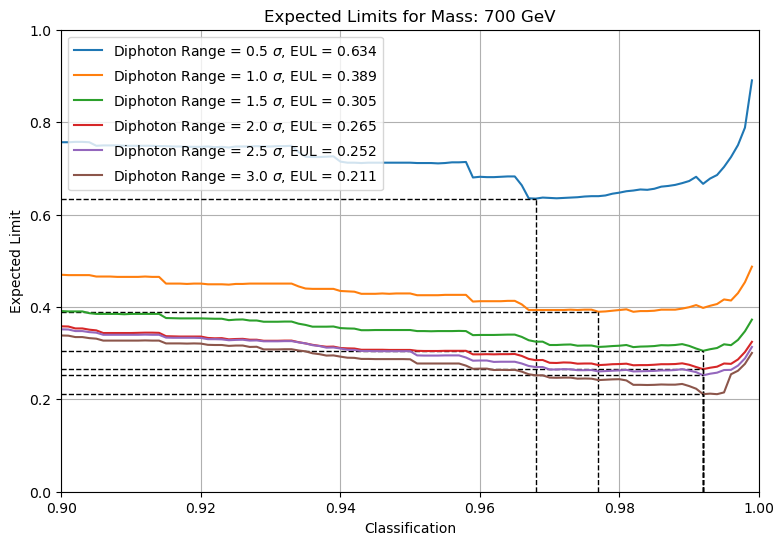

0.973
0.5847930908203125
0.975
0.3541946411132812
0.992
0.2737045288085937
0.992
0.2401351928710937
0.992
0.2283096313476562
0.992
0.1856803894042968


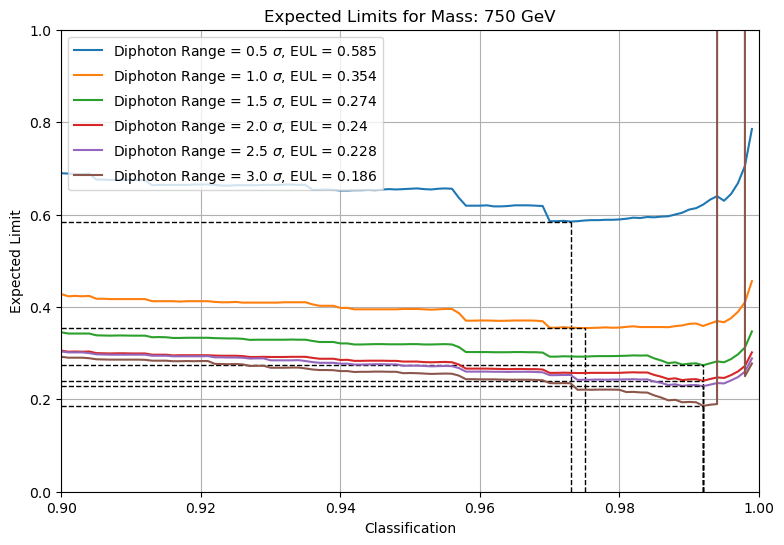

0.994
0.5847930908203125
0.99
0.3431320190429687
0.994
0.2706527709960937
0.994
0.2367019653320312
0.995
0.2241134643554687
0.99
0.1955032348632812


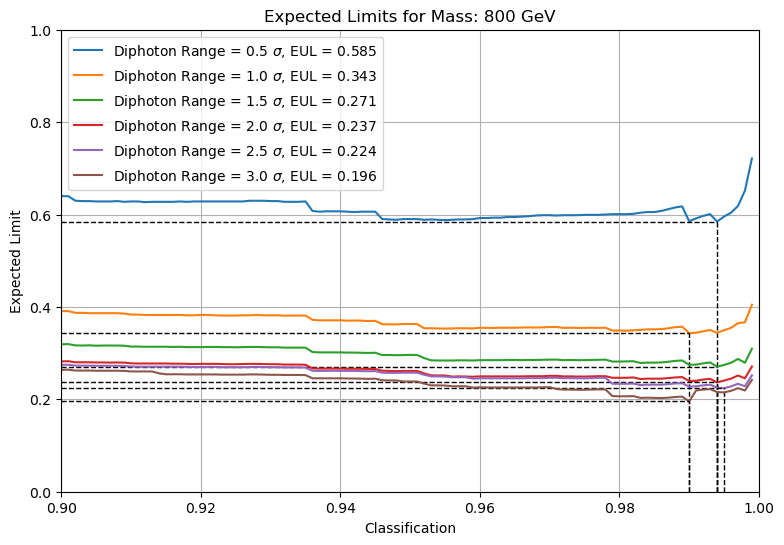

0.993
0.5268096923828125
0.993
0.2935409545898437
0.993
0.2328872680664062
0.993
0.2038955688476562
0.993
0.1902580261230468
0.993
0.1833915710449218


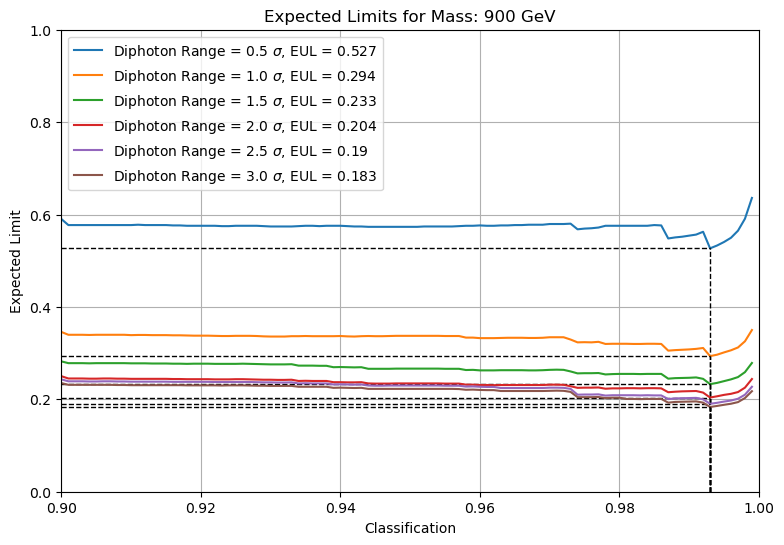

0.945
0.5077362060546875
0.972
0.2923965454101562
0.971
0.2305984497070312
0.976
0.2016067504882812
0.976
0.1868247985839843
0.981
0.1807212829589843


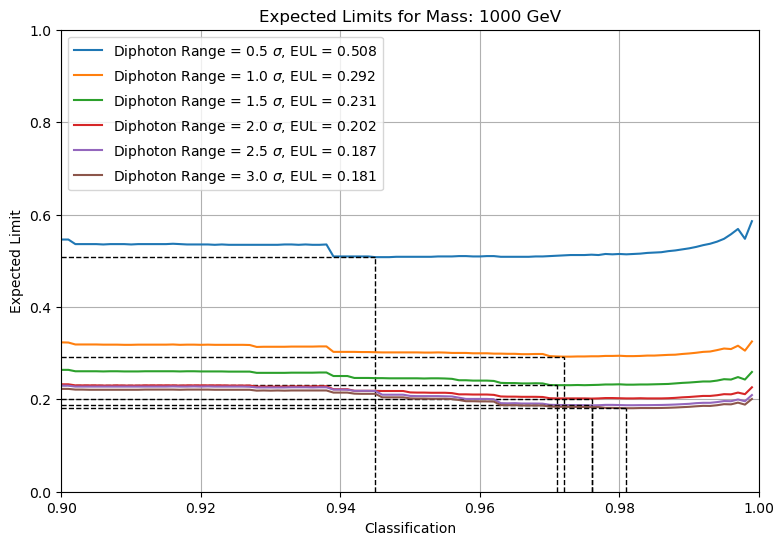

In [36]:
    #[[[124.25, 125.30]],[123.73,125.82],[123.21,126.34],[122.69,126.86],[122.17,127.39],[121.64,127.91]]
    # 0.5 1 1.5 2 2.5 3
allmasses=['260','270','280','290','300','320','350','400','450','500','550','600','650','700','750','800','900','1000']

for plot_mass_signal in allmasses:
   EL_plots = [f'thresholdupperlimitplots_{plot_mass_signal}_[124.25, 125.3].csv',
        f'thresholdupperlimitplots_{plot_mass_signal}_[123.73, 125.82].csv',
        f'thresholdupperlimitplots_{plot_mass_signal}_[123.21, 126.34].csv',
        f'thresholdupperlimitplots_{plot_mass_signal}_[122.69, 126.86].csv',
        f'thresholdupperlimitplots_{plot_mass_signal}_[122.17, 127.39].csv',
        f'thresholdupperlimitplots_{plot_mass_signal}_[121.64, 127.91].csv']
   lines_name = [r'0.5 $\sigma$', r'1.0 $\sigma$', r'1.5 $\sigma$', r'2.0 $\sigma$', r'2.5 $\sigma$', r'3.0 $\sigma$']
   fig = plt.figure(figsize=(9,6))
   lines = []  # Initialize an empty list to store plot lines
   j = 0
   for i in EL_plots:
        df = pd.read_csv(f'{directory}/ExpectedUpperLimit/{i}')
        thresh = df['threshold']
        expectedlim = df['expected_limits']
        minima=df[df['expected_limits']==min(expectedlim)].values
        min_thresh=minima[0][0]
        print(min_thresh)
        min_expectedlim=minima[0][1]
        plotline, = plt.plot(thresh, expectedlim, label=f'Diphoton Range = {lines_name[j]}, EUL = {round(minima[0][1],3)}')
        plt.axvline(min_thresh, color='black', linestyle='--', ymin=0, ymax=min_expectedlim,linewidth=1)
        plt.axhline(min_expectedlim, color='black', linestyle='--', xmin=0, xmax=(min_thresh*10-9),linewidth=1)


        print(min(expectedlim))
        lines.append(plotline)
        j += 1

   labels = [line.get_label() for line in lines]
   plt.legend(lines, labels,loc='upper left')
   plt.grid()
   plt.ylim(0, 1)
   plt.xlim(0.9,1)
   plt.ylabel('Expected Limit')
   plt.xlabel('Classification')
   plt.title(r'Expected Limits for Mass: {mass} GeV'.format(mass=plot_mass_signal))
   plt.show()

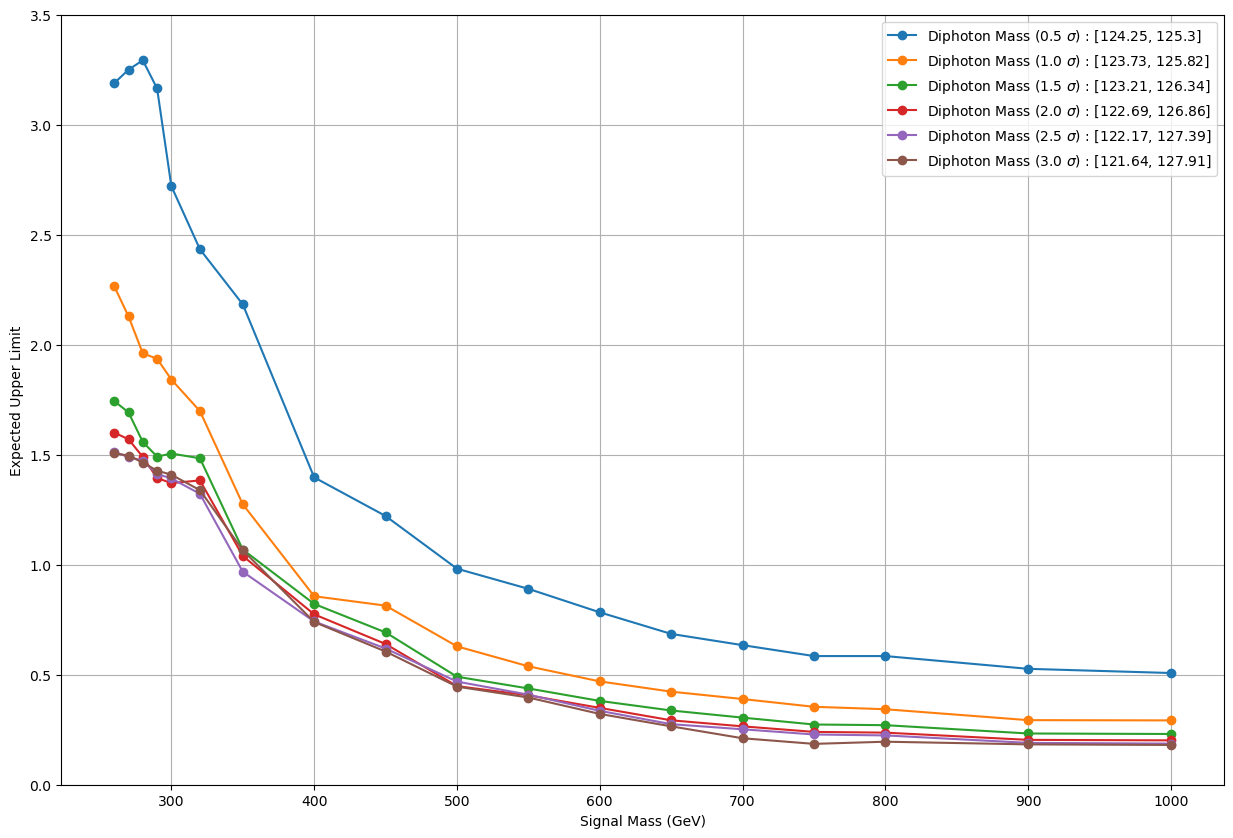

In [33]:
plotfordiphotonranges=['EUL_MX_MassRange_[124.25, 125.3].csv',
                       'EUL_MX_MassRange_[123.73, 125.82].csv',
                       'EUL_MX_MassRange_[123.21, 126.34].csv',
                       'EUL_MX_MassRange_[122.69, 126.86].csv',
                       'EUL_MX_MassRange_[122.17, 127.39].csv',
                       'EUL_MX_MassRange_[121.64, 127.91].csv']
Diphoton_ranges_names=['[124.25, 125.3]', '[123.73, 125.82]','[123.21, 126.34]','[122.69, 126.86]','[122.17, 127.39]','[121.64, 127.91]']
sigmas=[0.5,1.0,1.5,2.0,2.5,3.0]
int_masses =[int(i) for i in allmasses]
j=0
fig=plt.figure(figsize=(15,10))
for i in plotfordiphotonranges:
    df = pd.read_csv(f'{directory}/ExpectedUpperLimit/{i}')
    limits=df[f'{Diphoton_ranges_names[j]}'].values
    plt.plot(int_masses,limits,label=r'Diphoton Mass ({num} $\sigma$) : {dipmasses}'.format(num=sigmas[j],dipmasses=Diphoton_ranges_names[j]),marker='o') 
    j+=1
plt.grid()
plt.ylabel('Expected Upper Limit')
plt.ylim(0,3.5)
plt.xlabel('Signal Mass (GeV)')
plt.legend()
plt.show()


In [ ]:
import torch.nn as nn
def affineModel(features,nodes):
    if 'MX' in features:
        features.remove('MX')
    else:
        print('No mass feature appended')
        break
    layers.append(nn.Linear()())



class affinePNN(nn.Module):
  #  def __init__(self, input_size, hidden_size, output_size):
    def __init__(self, features, nodes):
        super(affinePNN, self).__init__()

        self.features=features
        self.nodes=nodes
        self.variables={}
        self.architecture=[nodes]

        hidden_name = f"linear_{0}"
        affine_name = f"affine_scale_{1}"
        affine_bias_name = f'affine_bias_{1}'
        self.dropout_layer = nn.Dropout()
        self.activation_layer = nn.ELU()
        self.sigmoid = nn.Sigmoid()

        linear_layer = nn.Linear(self.architecture[0][0], self.architecture[0][1])
        affine_layer = nn.Linear(self.architecture[0][1], self.architecture[0][2])
        affine_bias  = nn.Linear(self.architecture[0][1], self.architecture[0][2])

        self.variables[hidden_name] = linear_layer
        self.variables[affine_name] = affine_layer
        self.variables[affine_bias_name] = affine_bias

        for layer_index in range(0,len(self.architecture[0])-1):
            if layer_index != 0 and layer_index != 1:
                #print(layer_index)
                hidden_name = f"linear_{layer_index}"
                affine_name = f"affine__scale_{layer_index}"
                affine_bias_name = f'affine_bias_{layer_index}'

                
                linear_layer = nn.Linear(self.architecture[0][layer_index], self.architecture[0][layer_index])
                affine_layer = nn.Linear(self.architecture[0][layer_index], self.architecture[0][layer_index+1])
                affine_bias = nn.Linear(self.architecture[0][layer_index],self.architecture[0][layer_index+1])

                self.variables[hidden_name] = linear_layer
                self.variables[affine_name] = affine_layer
                self.variables[affine_bias_name] = affine_bias

    def forward(self, x, y):
        linear=self.variables.get('linear_0')
        x=linear(x)
        affine=self.variables.get('affine_scale_1')
        y=affine(y)
        x=x*y
        x=self.dropout_layer(x)
        x=self.activation_layer(x)

        for n in range(2,len(self.architecture[0])-1):
            linear=self.variables.get(f'linear_{n}')
            x=linear(x)
            affine_scale=self.variables.get(f'affine_scale_{n}')
            y1=affine_scale(y)
            affine_bias=self.variables.get(f'affine_bias_{n}')
            y2=affine_bias(y)

            x=x*y1+y2
            x=self.dropout_layer(x)
            x=self.activation_layer(x)
        
        x=self.sigmoid(x)
        return x